In [1]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import (
    normalise_data_chebyshev, 
    get_acf,
    Koopman_correlation_function,
    )
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import TSVD, Projection_Koopman_Space
import matplotlib
import plotly.graph_objects as go
from tqdm import tqdm
from LorenzEDMD.utils.paths import get_data_folder_path

matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

def get_Delta_moments(scaled : np.ndarray, edmd : EDMD_CHEB , batch_size : int = 100_000):
    n_total = scaled.shape[0]
    range_batches = range(0, n_total, batch_size)
    n_batches = len(range_batches)

    # Optional: get output shape from one batch
    example = edmd.evaluate_dictionary_batch(scaled[:1, :])
    avgs = np.zeros(example.shape[1])

    for i in tqdm(range_batches):
        batch = scaled[i:min(i + batch_size, n_total), :]
        Psi_trajectory = edmd.evaluate_dictionary_batch(batch)
        x_traj = batch[:, 0]
        avgs += np.mean(x_traj[:, None] * Psi_trajectory, axis=0)

    avgs /= n_batches
    return avgs

In [2]:
data_path = get_data_folder_path()
f_name = "edmd_smalldt.pkl"#"edmd_prova.pkl"

with open(data_path / f_name,"rb") as f:
    results = pickle.load(f)

EDMDS : List[List[EDMD_CHEB]] = results["edmd results"]
lorenz : lorenz63 = results["lorenz settings"] 

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

### Get the time series data

In [3]:
if not (data_path / "unperturbed.pkl").exists():
    
    with open(data_path / "unperturbed.pkl", "rb") as f:
        unperturbed_run = pickle.load(f)
    lorenz_cf_traj = unperturbed_run["Unperturbed Run"]
    t, X = lorenz_cf_traj.trajectory
else:
    lorenz_cf_traj = lorenz63()
    lorenz_cf_traj.noise = lorenz.noise
    lorenz_cf_traj.tau = 10
    lorenz_cf_traj.t_span = (0,10000)
    t, X = lorenz_cf_traj.integrate_EM()

scaled, data_min,data_max = normalise_data_chebyshev(X)

xmax , ymax, zmax = data_max
xmin, ymin, zmin = data_min
scale = (zmax - zmin) / 2 

scale = {
    "x" : (xmax - xmin) / 2 , 
    "y" : (ymax - ymin) / 2,
    "z" : (zmax- zmin) / 2,
    "x^2" : ( (xmax - xmin) / 2 )**2,
    "y^2" : ((ymax - ymin) / 2)**2,
    "z^2" : ((zmax- zmin) / 2) **2,
    "xy" : (xmax - xmin) / 2 * (ymax - ymin) / 2
}


100%|██████████| 10000000/10000000 [01:27<00:00, 114705.21it/s]


#### Fix a degree, regularise and get spectral properties

In [4]:
lags_response = np.arange(start=0.01,stop=30,step=0.01 )

In [10]:
selected_degrees = [14,16,18,20]
selected_thresholds = [-0.5 , -0.8 , -1.2 , -1.6, -100]

dictionary_save = {}
for selected_degree in selected_degrees:
    index = degrees.index(selected_degree)
    edmd : EDMD_CHEB = EDMDS[index][0]

    ### Define observable and get correlation properties
    # nlags = 1500
    # Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time

    # obs = scaled[:,2]
    # lags, cf = get_acf(obs, nlags = nlags,Dt=Dt)
    # lags_response = lags[1:]
    
    # Regularisation with TSVDS
    tsvd_regulariser = TSVD(rel_threshold=1e-4)
    Kreduced = tsvd_regulariser.decompose(edmd)

    # Get spectral properties
    tsvd_regulariser.get_spectral_properties()
    tsvd_regulariser.find_continuous_time_eigenvalues(lorenz_model=lorenz,edmd=edmd)

    ############# OBSERVABLE ##################
    ### Decomposition of observables on dictionary: exact decomposition
    decompositions = edmd.get_decomposition_observables()
    projections_dictionary = decompositions["z"]

    ### Decomposition on the svd basis
    projections_reduced = tsvd_regulariser.project_reduced_space(projections_dictionary)

    ############# RESPONSE OBSERVABLE ##################
    Ay = edmd.build_derivative_matrix(direction=1)
    avgs = get_Delta_moments(scaled=scaled,edmd = edmd)
    scalar_product_Gamma = Ay.T @ avgs
    Gamma_projections = tsvd_regulariser.Gr_inv @ scalar_product_Gamma
    Gamma_projections_reduced = tsvd_regulariser.project_reduced_space(Gamma_projections)

    ############# DECOMPOSITION IN KOOPMAN SPACE #######
    save_list_threshold = []
    for selected_threshold in selected_thresholds:
        koopman_space = Projection_Koopman_Space(threshold_lambda=selected_threshold)
        koopman_space.set_subspace(tsvd_regulariser)
        Gamma_projections_koopman = koopman_space.project_to_koopman_space(Gamma_projections_reduced)
        projections_koopman = koopman_space.project_to_koopman_space(projections_reduced)

        ############# SPECTRAL RECONSTRUCTION #######
        G_koop = koopman_space.reconstruct_correlation_function(coefficients_f=projections_koopman,coefficients_g=Gamma_projections_koopman)
        Green_Function_Koopman = np.array([G_koop(lag) for lag in lags_response])*scale["z"]
        save_list_threshold.append(np.real( Green_Function_Koopman) )
        
    dictionary_save[f"Response_degree_{selected_degree}"] = np.stack(save_list_threshold)
dictionary_save["degrees"] = selected_degrees
dictionary_save["threshold"] = selected_thresholds
dictionary_save["tresp"] = lags_response

100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


In [6]:
# data_path = get_data_folder_path()
# f_name = "multiple_reconstruction.pkl"

# with open(data_path / f_name, "wb") as f:
#     pickle.dump(dictionary_save, f)

(-1.0, 10.0)

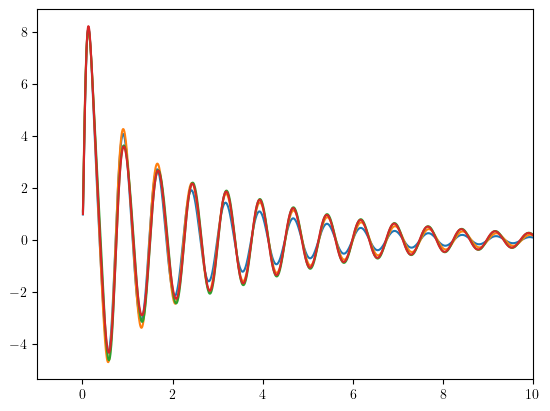

In [11]:
fig, ax = plt.subplots()
index_degree = -1
ax.plot(dictionary_save["tresp"],dictionary_save["Response_degree_14"][index_degree,:])
ax.plot(dictionary_save["tresp"],dictionary_save["Response_degree_16"][index_degree,:])
ax.plot(dictionary_save["tresp"],dictionary_save["Response_degree_18"][index_degree,:])
ax.plot(dictionary_save["tresp"],dictionary_save["Response_degree_20"][index_degree,:])
ax.set_xlim(-1,10)

In [ ]:
# from scipy.io import savemat
# savemat("Multiple_Responses.mat",dictionary_save)

In [15]:
sigma = 0.7
np.pi / (2*np.sqrt(2)) *np.exp(2/ sigma**2 )

np.float64(65.80144299267707)